In [88]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
from model import TimeSeriesTransformer

plt.style.use('seaborn-v0_8-whitegrid')
mpl.rc('font', family='sans-serif', weight='bold')
mpl.rc('axes', labelsize=18, titlesize=24, labelweight='bold', titleweight='bold')
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rc('legend', fontsize=14)
mpl.rc('lines', linewidth=2.5)

# Model

Our model is a 3-layer self-attention transformer with causal mask:
- Because the available training dataset is relatively small, we deliberately limit the network depth to 3 layers to reduce overfitting and improve generalization.
- A causal (look-back) mask is applied in the self-attention mechanism to ensure that, at each timestep, the model only attends to current and past sensor readings. This prevents information leakage from future measurements and enforces the correct temporal ordering of the process data.

## Input data and Prediction
**TimeSeriesTransformer**
- **Input Data**: 
    - Input dimension: 97
    - Details: The MinMax scaled 91 measurements + one-hot encoded label (sampling point).
- **Prediction**
    - Output dimension: 6
    - Details: CO2 concentration at 6 sampling points.

**TimeSeriesTransformer-SF**
- **Input Data**: 
    - Input dimension: 38
    - Details: The MinMax scaled 32 selected measurements by PCA + one-hot encoded label (sampling point).
- **Prediction**
    - Output dimension: 6
    - Details: CO2 concentration at 6 sampling points.

## Loss
The loss function used in this task is Mean Square Error (MSE).


# Evaluation

The trained model is tested on the processed `140207_1.xlsx`. The processed test data is in `processed_data/test_data.csv`.

The processed test dataset is **normalised** by the maximum and minimum scales of each columns from **training dataset**.

## How to evaluation
### Full Sequence
1. Start with the first measurement and use it to generate the first prediction.
2. As new measurements arrive, append them to the sequence and feed the updated window into the model.
3. Continue this process until the input reaches the defined window size.
4. After the window is full, apply a sliding-window approach: at each step, drop the oldest measurement and append the newest one.
5. Repeat the sliding-window prediction process until the entire test dataset has been evaluated.
### Start from window size (provided GitHub used)
1. Accumulate measurements until input reaches the defined window size.
2. Apply a sliding-window approach: at each step, drop the oldest measurement and append the newest one.
3. Repeat the sliding-window prediction process until the entire test dataset has been evaluated.
## Evaluation Metrics

The Evaluation Metric used in this task is RMSE.

# TimeSeriesTransformer
## Load Test Data


In [89]:
# load processed test data
test_data_path = './processed_data/test_data.csv'
test_data_df = pd.read_csv(test_data_path)
print(test_data_df.head())

CO2_scale = 12.03671837

# define target column
target_columns = ['1_sampling', '2_sampling', '3_sampling', 
                  '4_sampling', '5_sampling', '6_sampling']
print(f"target_columns:\nnumber of target columns:{len(target_columns)}\n{target_columns}")

# define feature column
all_columns = list(test_data_df.columns)
excluded = target_columns + ['time']
feature_columns = [col for col in all_columns if col not in excluded]
print(f"feature_columns:\nnumber of feature columns:{len(feature_columns)}\n{feature_columns}")

                  time  AT100(pH)  AT300(pH)  AT400(CO2 %)  FT100(kg/hr)  \
0  2014-02-07 11:56:10   0.460428   0.748592           0.0      0.386921   
1  2014-02-07 11:56:53   0.471397   0.746150           0.0      0.558722   
2  2014-02-07 11:57:36   0.477013   0.745836           0.0      0.532554   
3  2014-02-07 11:58:19   0.487057   0.743099           0.0      0.633461   
4  2014-02-07 11:59:02   0.490434   0.742085           0.0      0.610531   

   FT101(kg/hr)  FT102(kg/hr)  FT103(kg/hr)  FT104(kg/hr)  FT105(L/min)  ...  \
0             0      0.000000      0.832740  0.000000e+00      0.001696  ...   
1             0      0.000000      0.833478  0.000000e+00      0.001399  ...   
2             0      0.002109      0.830185  0.000000e+00      0.001371  ...   
3             0      0.068775      0.831828  3.556363e-02      0.001351  ...   
4             0      0.102117      0.834594  3.898870e-09      0.001515  ...   

   TT411(0C)  TT412(0C)  TT413(0C)  label    1_sampling  2_sam

features.shape: (118, 97)
targets.shape: (118, 6)


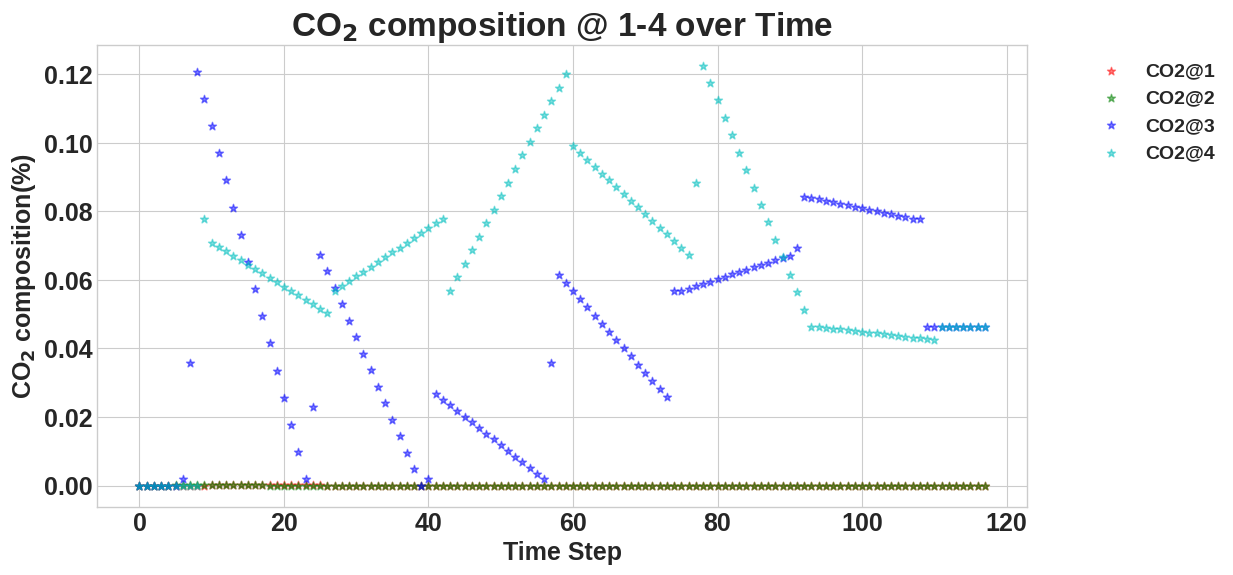

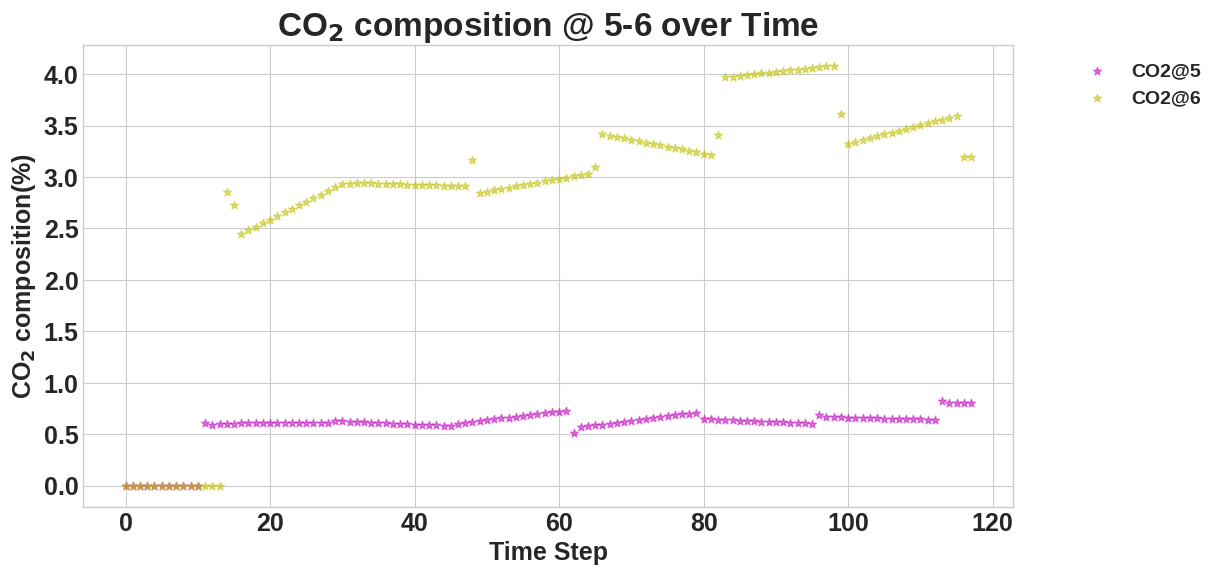

In [90]:
# extract features and labels
features = test_data_df[feature_columns].values.astype(np.float32)
labels = test_data_df['label'].values.astype(np.int64)

# convert labels (1-6) to one-hot encoding (6 classes)
labels_onehot = np.eye(6)[labels - 1].astype(np.float32)  # Subtract 1 to make it 0-5 indexed
# generate the final feature set
features = np.concatenate([features, labels_onehot], axis=-1)
print(f'features.shape: {features.shape}')

# extract targets
targets = test_data_df[target_columns].values.astype(np.float32) * CO2_scale
print(f'targets.shape: {targets.shape}')
# convert to torch tensors
features = torch.from_numpy(features)

fig = plt.figure(figsize=(12, 6))
plt.scatter(range(targets.shape[0]), targets[:,0], marker='*', color='r', alpha=0.5, label='CO2@1')
plt.scatter(range(targets.shape[0]), targets[:,1], marker='*', color='g', alpha=0.5, label='CO2@2')
plt.scatter(range(targets.shape[0]), targets[:,2], marker='*', color='b', alpha=0.5, label='CO2@3')
plt.scatter(range(targets.shape[0]), targets[:,3], marker='*', color='c', alpha=0.5, label='CO2@4')

plt.xlabel('Time Step')
plt.ylabel('CO$_2$ composition(%)')
plt.title('CO$_2$ composition @ 1-4 over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.scatter(range(targets.shape[0]), targets[:,4], marker='*', color='m', alpha=0.5, label='CO2@5')
plt.scatter(range(targets.shape[0]), targets[:,5], marker='*', color='y', alpha=0.5, label='CO2@6')

plt.xlabel('Time Step')
plt.ylabel('CO$_2$ composition(%)')
plt.title('CO$_2$ composition @ 5-6 over Time')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



## Test Trained Model on Test dataset

In [91]:
# test the trained model
PREDs = []
for window_sizes in range(2,51,1):
    # load the trained model
    model_path = os.path.join('Chi_models/CO2_Estimation/TimeSeriesTransformer', str(window_sizes), 'model.pth.tar')
    model = TimeSeriesTransformer(
            input_dim=97,
            d_model=192,
            n_heads=3,
            n_layers=3,
            d_ff=384,
            max_seq_len=window_sizes,
            output_dim=6,
            dropout=0.1
        ).cuda()

    ckpt = torch.load(model_path, map_location='cuda', weights_only=False)
    model.load_state_dict(ckpt['state_dict'])
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(features.shape[0]):
            if i < (window_sizes - 1):
                inputs = features[:i+1, :].unsqueeze(0).cuda()
                outputs = model(inputs, use_causal_mask=True)
                predictions.append(outputs)
            else:
                inputs = features[i-window_sizes+1:i+1, :].unsqueeze(0).cuda()
                outputs = model(inputs, use_causal_mask=True)
                predictions.append(outputs)
    predictions = torch.cat(predictions, dim=0).squeeze(0).cpu().numpy()
    PREDs.append(predictions)
PREDs = np.array(PREDs) * CO2_scale  # Shape: (num_window_sizes, num_samples, 6)
print(f'PREDs.shape: {PREDs.shape}')

PREDs.shape: (49, 118, 6)


## Evaluation (Full Sequence)

At the start of each run, sampling points 2–6 have **no analyzer measurements**. During preprocessing, linear interpolation fills these gaps, which results in initial CO₂ (%) values being set to **zero**. These zeros are not physically meaningful, so we exclude the corresponding initial timesteps from full-sequence evaluation.

The number of testing data is the **same** for all models.

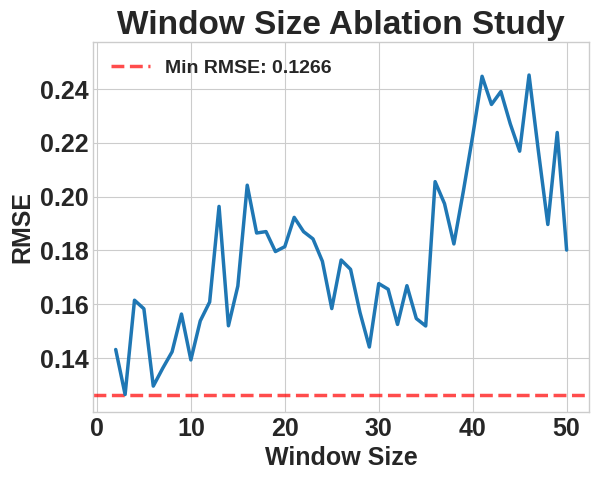

The Minimum RMSE is 0.1266 at window size 3


In [92]:
start_idx = 14

RMSEs_all = np.sqrt(((PREDs[:, start_idx:, :] - targets[start_idx:, :][np.newaxis, :])**2).mean(axis=-1)).mean(axis=-1)


min_rmse = min(RMSEs_all)
plt.axhline(y=min_rmse, color='red', linestyle='--', alpha=0.7, label=f'Min RMSE: {min_rmse:.4f}')
plt.legend()
plt.plot(range(2,51,1), RMSEs_all)
plt.ylim(0.95*min_rmse, 1.05*max(RMSEs_all))
plt.xlabel('Window Size')
plt.ylabel('RMSE')
plt.title('Window Size Ablation Study')
plt.grid(True)
plt.show()
print(f'The Minimum RMSE is {min_rmse:.4f} at window size {np.argmin(RMSEs_all)+2}')  # +2 because window sizes start from 2

## Evaluation (Start from Window Size)

Evaluation begins only after the model’s input window is filled. As a result, the number of available test samples (**different**) depends on the predefined window size.

Errors from early steps are included in the RMSE calculation, the overall RMSE of small window size is higher than that of large window size.

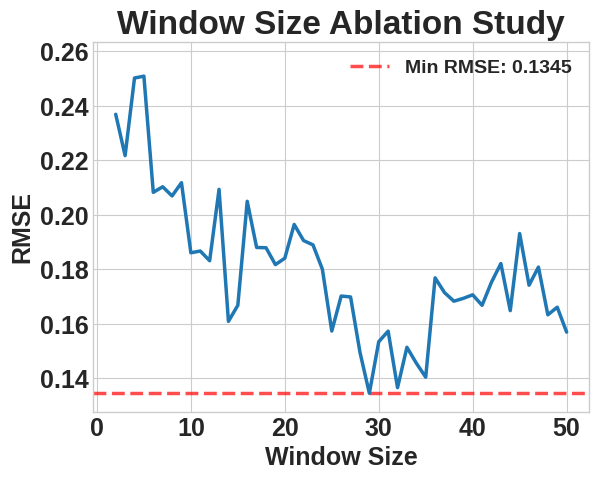

The Minimum RMSE is 0.1345 at window size 29


In [93]:
RMSEs_all = []
for ws in range(2, 51, 1):
    idx = ws - 2  # because window sizes start from 2
    RMSEs_all.append(np.sqrt(((PREDs[idx, ws-1:, :] - targets[ws-1:, :])**2).mean(axis=-1)).mean())

min_rmse = min(RMSEs_all)
plt.axhline(y=min_rmse, color='red', linestyle='--', alpha=0.7, label=f'Min RMSE: {min_rmse:.4f}')
plt.legend()
plt.plot(range(2,51,1), RMSEs_all)
plt.ylim(0.95*min_rmse, 1.05*max(RMSEs_all))
plt.xlabel('Window Size')
plt.ylabel('RMSE')
plt.title('Window Size Ablation Study')
plt.grid(True)
plt.show()
print(f'The Minimum RMSE is {min_rmse:.4f} at window size {np.argmin(RMSEs_all)+2}')  # +2 because window sizes start from 2



## Analysis of TimeSeriesTransformer -- Window Size=3

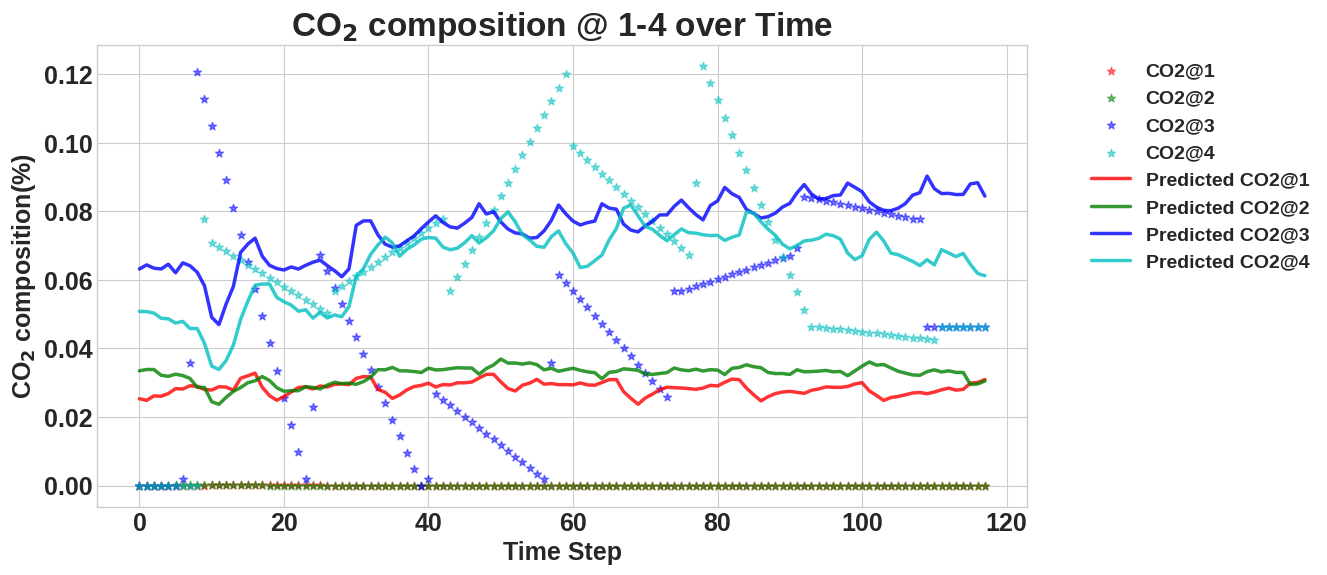

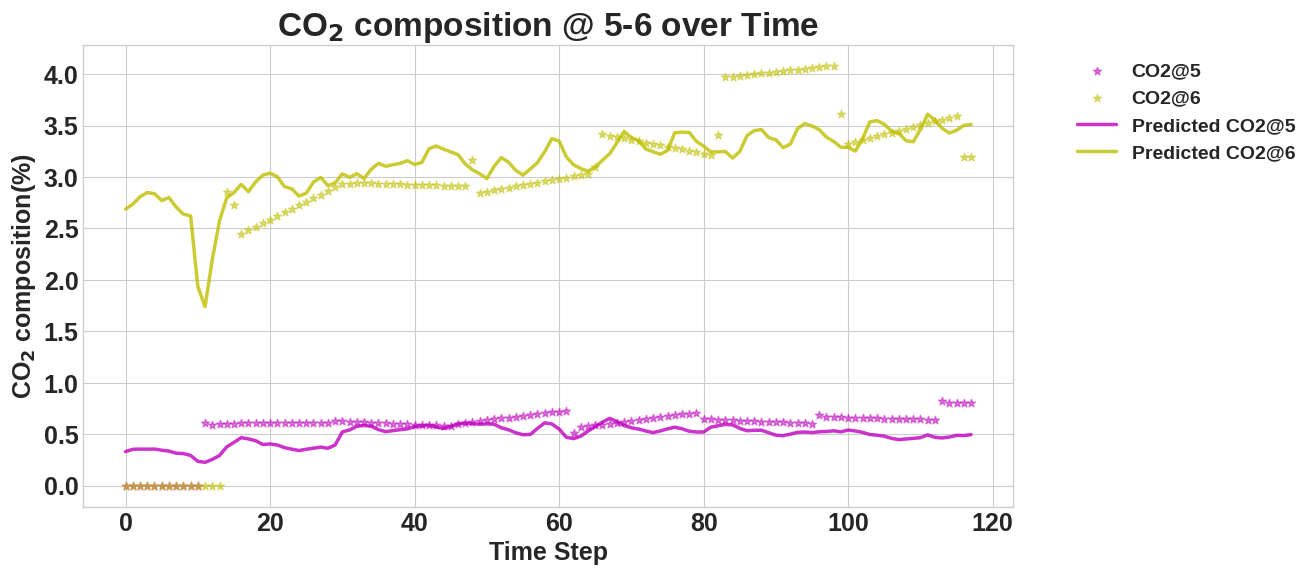

In [94]:
index_of_best = 1
fig = plt.figure(figsize=(12, 6))
plt.scatter(range(targets.shape[0]), targets[:,0], marker='*', color='r', alpha=0.5, label='CO2@1')
plt.scatter(range(targets.shape[0]), targets[:,1], marker='*', color='g', alpha=0.5, label='CO2@2')
plt.scatter(range(targets.shape[0]), targets[:,2], marker='*', color='b', alpha=0.5, label='CO2@3')
plt.scatter(range(targets.shape[0]), targets[:,3], marker='*', color='c', alpha=0.5, label='CO2@4')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,0], color='r', alpha=0.8, label='Predicted CO2@1')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,1], color='g', alpha=0.8, label='Predicted CO2@2')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,2], color='b', alpha=0.8, label='Predicted CO2@3')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,3], color='c', alpha=0.8, label='Predicted CO2@4')

plt.xlabel('Time Step')
plt.ylabel('CO$_2$ composition(%)')
plt.title('CO$_2$ composition @ 1-4 over Time')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.scatter(range(targets.shape[0]), targets[:,4], marker='*', color='m', alpha=0.5, label='CO2@5')
plt.scatter(range(targets.shape[0]), targets[:,5], marker='*', color='y', alpha=0.5, label='CO2@6')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,4], color='m', alpha=0.8, label='Predicted CO2@5')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,5], color='y', alpha=0.8, label='Predicted CO2@6')

plt.xlabel('Time Step')
plt.ylabel('CO$_2$ composition(%)')
plt.title('CO$_2$ composition @ 5-6 over Time')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Analysis of TimeSeriesTransformer -- Window Size=29

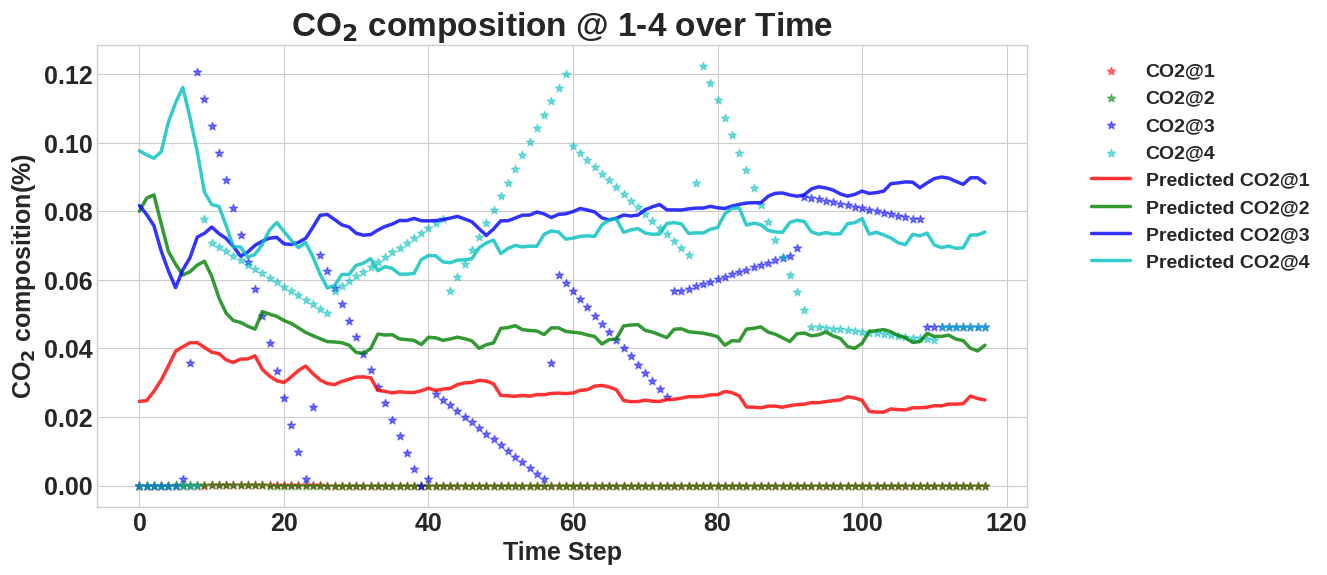

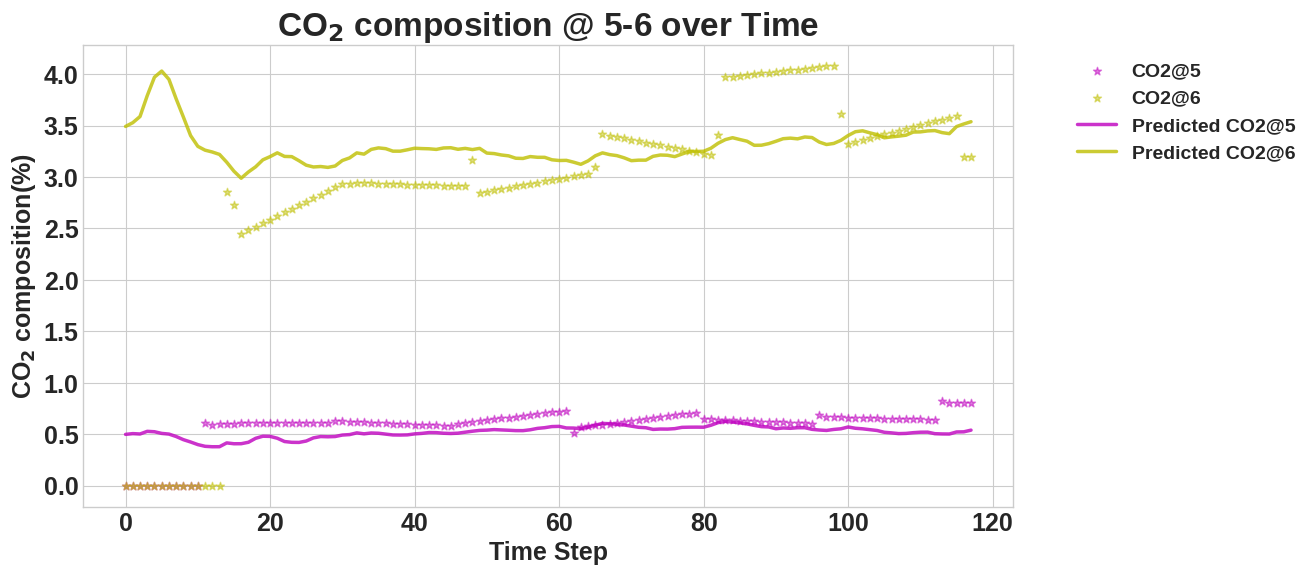

In [95]:
index_of_best = 27
fig = plt.figure(figsize=(12, 6))
plt.scatter(range(targets.shape[0]), targets[:,0], marker='*', color='r', alpha=0.5, label='CO2@1')
plt.scatter(range(targets.shape[0]), targets[:,1], marker='*', color='g', alpha=0.5, label='CO2@2')
plt.scatter(range(targets.shape[0]), targets[:,2], marker='*', color='b', alpha=0.5, label='CO2@3')
plt.scatter(range(targets.shape[0]), targets[:,3], marker='*', color='c', alpha=0.5, label='CO2@4')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,0], color='r', alpha=0.8, label='Predicted CO2@1')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,1], color='g', alpha=0.8, label='Predicted CO2@2')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,2], color='b', alpha=0.8, label='Predicted CO2@3')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,3], color='c', alpha=0.8, label='Predicted CO2@4')

plt.xlabel('Time Step')
plt.ylabel('CO$_2$ composition(%)')
plt.title('CO$_2$ composition @ 1-4 over Time')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.scatter(range(targets.shape[0]), targets[:,4], marker='*', color='m', alpha=0.5, label='CO2@5')
plt.scatter(range(targets.shape[0]), targets[:,5], marker='*', color='y', alpha=0.5, label='CO2@6')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,4], color='m', alpha=0.8, label='Predicted CO2@5')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,5], color='y', alpha=0.8, label='Predicted CO2@6')

plt.xlabel('Time Step')
plt.ylabel('CO$_2$ composition(%)')
plt.title('CO$_2$ composition @ 5-6 over Time')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Comparison between model with window size of 3 and 29

The main difference between both models is the prediction from the first 15 time stamps.
- window size = 3
    - Predictions during the first 15 timesteps tend to be much closer to zero. This behavior lowers the error in full-sequence evaluation, which is why this model performs better in that metric.
    - However, because errors from these early steps are included in the RMSE calculation, the overall RMSE is higher compared with the model trained with a larger window size (e.g., 29).
- window size = 29
    - With a longer context window, the model avoids the initial bias toward zero but excludes the earliest timesteps from evaluation. This leads to a lower RMSE in window-based evaluation but slightly weaker performance in full-sequence evaluation.

**Conclusion**:

Based on above reasons and figures, the model trained with a **window size of 3** performs better on this test dataset, likely because the training dataset is relatively small.

# TimeSeriesTransformer-SF

Instead of using all features from the dataset, we use the features selected by PCA (in GitHub) to train the model.

In [96]:
# load processed test data
test_data_path = './processed_data/test_data.csv'
test_data_df = pd.read_csv(test_data_path)

CO2_scale = 12.03671837

# define target column
target_columns = ['1_sampling', '2_sampling', '3_sampling', 
                  '4_sampling', '5_sampling', '6_sampling']
print(f"target_columns:\nnumber of target columns:{len(target_columns)}\n{target_columns}")

# define feature columns
feature_columns = ['TT302(0C)','TT300(0C)','TT401(0C)','TT303(0C)','TT400(0C)','TT113(0C)',
                    'TT301(0C)','TT202(0C)','TT412(0C)','TT309(0C)','TT110a(0C)','TT410(0C)',
                    'TT112(0C)','PT103(barg)','PT402(barg)','PT401(barg)','TT404(0C)', 'TT214(0C)',
                    'FT304(kg/hr)','AT100(pH)','FT303m3/hr','AT300(pH)','FT105(L/min)','FT103(kg/hr)',
                    'PT403(barg)','TT304(0C)','FT301m3/hr','TT107(0C)', 'PT110(barg)','PT111(barg)',
                    'TT210(0C)','TT211(0C)']
print(f"feature_columns:\nnumber of feature columns:{len(feature_columns)}\n{feature_columns}")

# extract features and labels
features = test_data_df[feature_columns].values.astype(np.float32)
labels = test_data_df['label'].values.astype(np.int64)

# convert labels (1-6) to one-hot encoding (6 classes)
labels_onehot = np.eye(6)[labels - 1].astype(np.float32)  # Subtract 1 to make it 0-5 indexed
# generate the final feature set
features = np.concatenate([features, labels_onehot], axis=-1)
print(f'features.shape: {features.shape}')

# extract targets
targets = test_data_df[target_columns].values.astype(np.float32) * CO2_scale
print(f'targets.shape: {targets.shape}')
# convert to torch tensors
features = torch.from_numpy(features)

target_columns:
number of target columns:6
['1_sampling', '2_sampling', '3_sampling', '4_sampling', '5_sampling', '6_sampling']
feature_columns:
number of feature columns:32
['TT302(0C)', 'TT300(0C)', 'TT401(0C)', 'TT303(0C)', 'TT400(0C)', 'TT113(0C)', 'TT301(0C)', 'TT202(0C)', 'TT412(0C)', 'TT309(0C)', 'TT110a(0C)', 'TT410(0C)', 'TT112(0C)', 'PT103(barg)', 'PT402(barg)', 'PT401(barg)', 'TT404(0C)', 'TT214(0C)', 'FT304(kg/hr)', 'AT100(pH)', 'FT303m3/hr', 'AT300(pH)', 'FT105(L/min)', 'FT103(kg/hr)', 'PT403(barg)', 'TT304(0C)', 'FT301m3/hr', 'TT107(0C)', 'PT110(barg)', 'PT111(barg)', 'TT210(0C)', 'TT211(0C)']
features.shape: (118, 38)
targets.shape: (118, 6)


# Test Trained Mode-SF on Test dataset

In [97]:
# test the trained model
PREDs = []
for window_sizes in range(2,51,1):
    # load the trained model
    model_path = os.path.join('Chi_models/CO2_Estimation/TimeSeriesTransformer_SF', str(window_sizes), 'model.pth.tar')
    model = TimeSeriesTransformer(
            input_dim=38,
            d_model=192,
            n_heads=3,
            n_layers=3,
            d_ff=384,
            max_seq_len=window_sizes,
            output_dim=6,
            dropout=0.1
        ).cuda()

    ckpt = torch.load(model_path, map_location='cuda', weights_only=False)
    model.load_state_dict(ckpt['state_dict'])
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(features.shape[0]):
            if i < (window_sizes - 1):
                inputs = features[:i+1, :].unsqueeze(0).cuda()
                outputs = model(inputs, use_causal_mask=True)
                predictions.append(outputs)
            else:
                inputs = features[i-window_sizes+1:i+1, :].unsqueeze(0).cuda()
                outputs = model(inputs, use_causal_mask=True)
                predictions.append(outputs)
    predictions = torch.cat(predictions, dim=0).squeeze(0).cpu().numpy()
    PREDs.append(predictions)
PREDs = np.array(PREDs) * CO2_scale  # Shape: (num_window_sizes, num_samples, 6)
print(f'PREDs.shape: {PREDs.shape}')

PREDs.shape: (49, 118, 6)


## Evaluation (Full Sequence)

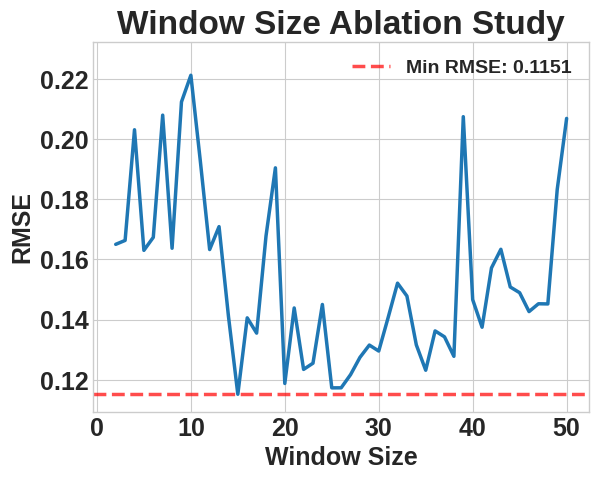

The Minimum RMSE is 0.1151 at window size 15


In [98]:
start_idx = 14

RMSEs_all = np.sqrt(((PREDs[:, start_idx:, :] - targets[start_idx:, :][np.newaxis, :])**2).mean(axis=(-1))).mean(axis=-1)


min_rmse = min(RMSEs_all)
plt.axhline(y=min_rmse, color='red', linestyle='--', alpha=0.7, label=f'Min RMSE: {min_rmse:.4f}')
plt.legend()
plt.plot(range(2,51,1), RMSEs_all)
plt.ylim(0.95*min_rmse, 1.05*max(RMSEs_all))
plt.xlabel('Window Size')
plt.ylabel('RMSE')
plt.title('Window Size Ablation Study')
plt.grid(True)
plt.show()
print(f'The Minimum RMSE is {min_rmse:.4f} at window size {np.argmin(RMSEs_all)+2}')  # +2 because window sizes start from 2

## Evaluation (Start from Window Size)

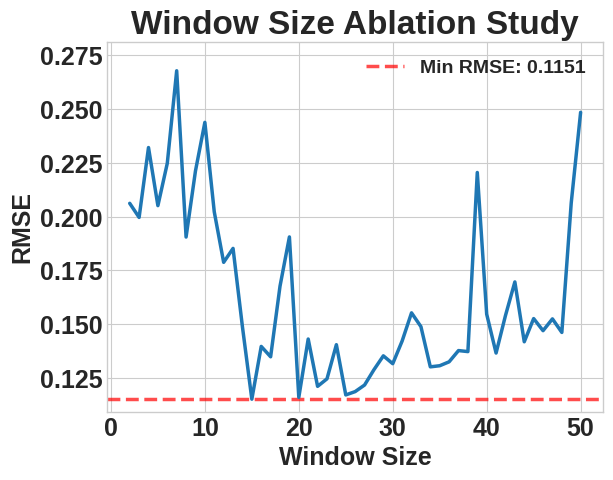

The Minimum RMSE is 0.1151 at window size 15


In [99]:
RMSEs_all = []
for ws in range(2, 51, 1):
    idx = ws - 2  # because window sizes start from 2
    RMSEs_all.append(np.sqrt(((PREDs[idx, ws-1:, :] - targets[ws-1:, :])**2).mean(axis=-1)).mean())
    
min_rmse = min(RMSEs_all)
plt.axhline(y=min_rmse, color='red', linestyle='--', alpha=0.7, label=f'Min RMSE: {min_rmse:.4f}')
plt.legend()
plt.plot(range(2,51,1), RMSEs_all)
plt.ylim(0.95*min_rmse, 1.05*max(RMSEs_all))
plt.xlabel('Window Size')
plt.ylabel('RMSE')
plt.title('Window Size Ablation Study')
plt.grid(True)
plt.show()
print(f'The Minimum RMSE is {min_rmse:.4f} at window size {np.argmin(RMSEs_all)+2}')  # +2 because window sizes start from 2



## Analysis of TimeSeriesTransformer-SF -- window size = 15

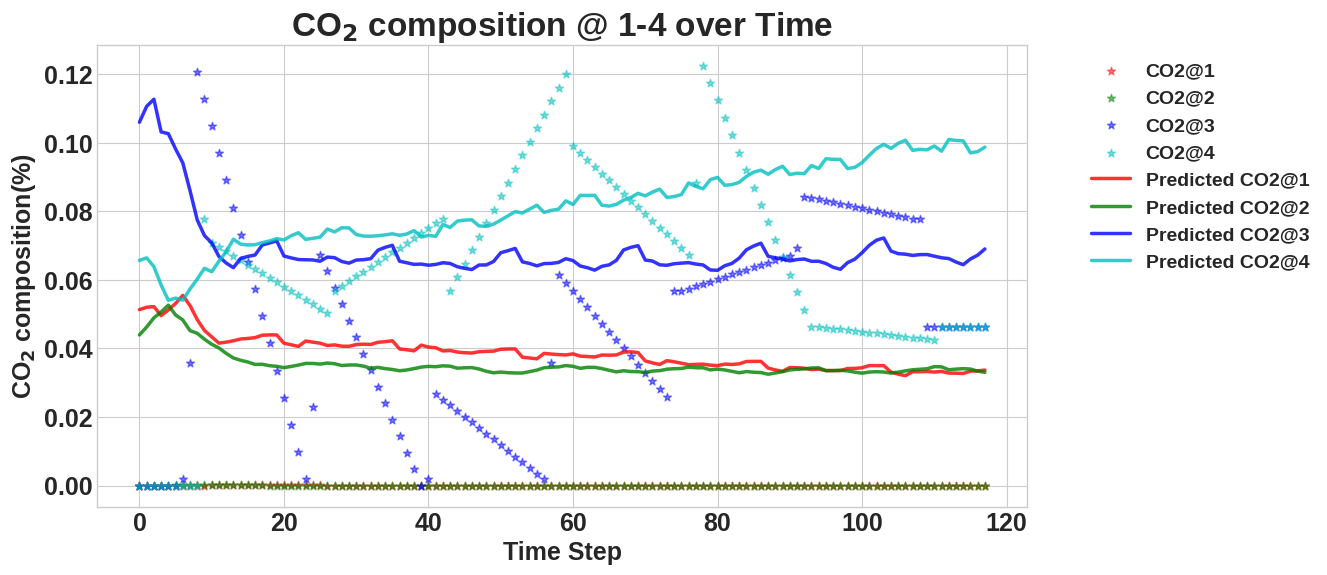

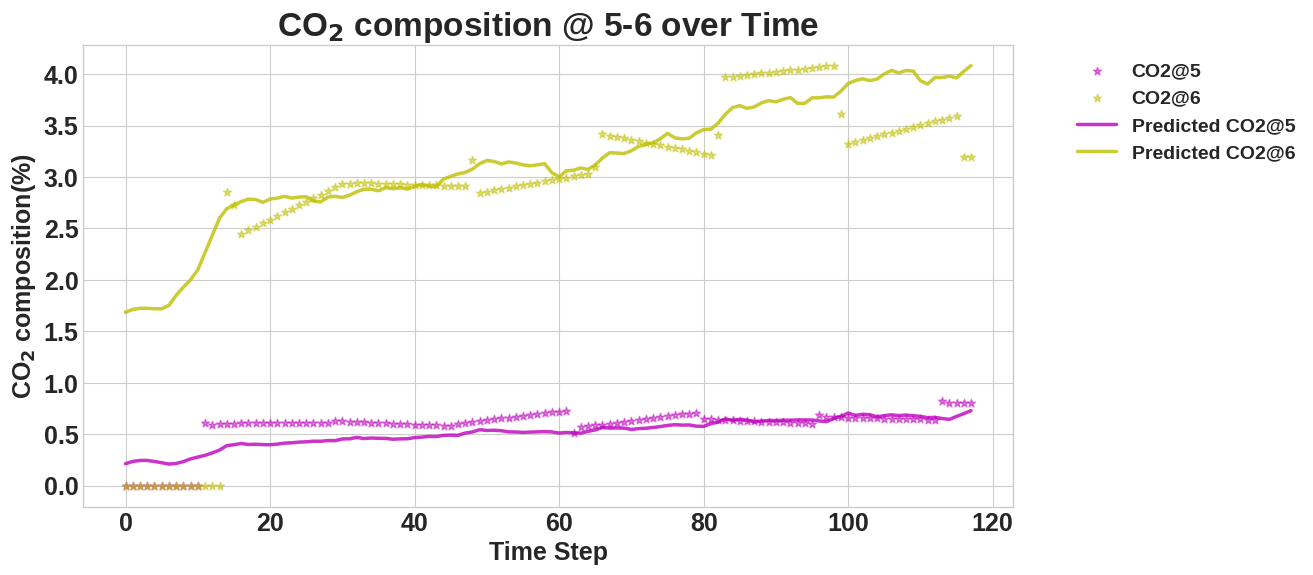

In [100]:
index_of_best = 13
fig = plt.figure(figsize=(12, 6))
plt.scatter(range(targets.shape[0]), targets[:,0], marker='*', color='r', alpha=0.5, label='CO2@1')
plt.scatter(range(targets.shape[0]), targets[:,1], marker='*', color='g', alpha=0.5, label='CO2@2')
plt.scatter(range(targets.shape[0]), targets[:,2], marker='*', color='b', alpha=0.5, label='CO2@3')
plt.scatter(range(targets.shape[0]), targets[:,3], marker='*', color='c', alpha=0.5, label='CO2@4')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,0], color='r', alpha=0.8, label='Predicted CO2@1')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,1], color='g', alpha=0.8, label='Predicted CO2@2')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,2], color='b', alpha=0.8, label='Predicted CO2@3')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,3], color='c', alpha=0.8, label='Predicted CO2@4')

plt.xlabel('Time Step')
plt.ylabel('CO$_2$ composition(%)')
plt.title('CO$_2$ composition @ 1-4 over Time')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.scatter(range(targets.shape[0]), targets[:,4], marker='*', color='m', alpha=0.5, label='CO2@5')
plt.scatter(range(targets.shape[0]), targets[:,5], marker='*', color='y', alpha=0.5, label='CO2@6')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,4], color='m', alpha=0.8, label='Predicted CO2@5')
plt.plot(range(PREDs.shape[1]), PREDs[index_of_best,:,5], color='y', alpha=0.8, label='Predicted CO2@6')

plt.xlabel('Time Step')
plt.ylabel('CO$_2$ composition(%)')
plt.title('CO$_2$ composition @ 5-6 over Time')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Conclusion
Based on both evaluation methods (full-sequence and window-based), the **TimeSeriesTransformer-SF-w15** achieved the best performance, with an RMSE of **0.1151**, outperforming both the TimeSeriesTransformer-w3 and TimeSeriesTransformer-w29 models.

The analysis of prediction trends further confirms its superiority:
- **Sampling point 6**: The ground-truth CO₂ composition shows an upward trend. Only the TimeSeriesTransformer-SF-w15 successfully captured this increasing trend, while the other models failed to reproduce it.
- **Sampling points 3 and 4**: The predicted curves from TimeSeriesTransformer-SF-w15 align more closely with the ground truth compared to the other models, indicating better local accuracy.

Overall, the **TimeSeriesTransformer-SF-w15** not only achieves the lowest error but also demonstrates stronger ability to capture the true dynamics of CO₂ concentration profiles across absorber sampling points.

